# Deep Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')

[2017-06-18 17:53:10,376] Making new env: CartPole-v0


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
rewards = []
for _ in range(100):
    env.render()
    state, reward, done, info = env.step(env.action_space.sample()) # take a random action
    rewards.append(reward)
    if done:
        rewards = []
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])


[1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [6]:
class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [7]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [8]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [9]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [10]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [11]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole.ckpt")


Episode: 1 Total reward: 9.0 Training loss: 1.0187 Explore P: 0.9991
Episode: 2 Total reward: 43.0 Training loss: 1.0473 Explore P: 0.9949
Episode: 3 Total reward: 13.0 Training loss: 1.0396 Explore P: 0.9936
Episode: 4 Total reward: 14.0 Training loss: 1.0261 Explore P: 0.9922
Episode: 5 Total reward: 17.0 Training loss: 1.0569 Explore P: 0.9905
Episode: 6 Total reward: 16.0 Training loss: 0.9371 Explore P: 0.9890
Episode: 7 Total reward: 38.0 Training loss: 1.0635 Explore P: 0.9853
Episode: 8 Total reward: 45.0 Training loss: 1.0084 Explore P: 0.9809
Episode: 9 Total reward: 66.0 Training loss: 1.0292 Explore P: 0.9745
Episode: 10 Total reward: 11.0 Training loss: 0.9912 Explore P: 0.9734
Episode: 11 Total reward: 17.0 Training loss: 1.2568 Explore P: 0.9718
Episode: 12 Total reward: 16.0 Training loss: 1.1737 Explore P: 0.9703
Episode: 13 Total reward: 37.0 Training loss: 1.1402 Explore P: 0.9667
Episode: 14 Total reward: 15.0 Training loss: 1.1157 Explore P: 0.9653
Episode: 15 Tota

Episode: 119 Total reward: 32.0 Training loss: 4.0457 Explore P: 0.7892
Episode: 120 Total reward: 23.0 Training loss: 101.4911 Explore P: 0.7874
Episode: 121 Total reward: 19.0 Training loss: 35.4503 Explore P: 0.7860
Episode: 122 Total reward: 17.0 Training loss: 3.7205 Explore P: 0.7846
Episode: 123 Total reward: 12.0 Training loss: 4.5772 Explore P: 0.7837
Episode: 124 Total reward: 10.0 Training loss: 93.0962 Explore P: 0.7829
Episode: 125 Total reward: 15.0 Training loss: 128.0328 Explore P: 0.7818
Episode: 126 Total reward: 20.0 Training loss: 56.0087 Explore P: 0.7802
Episode: 127 Total reward: 12.0 Training loss: 3.0584 Explore P: 0.7793
Episode: 128 Total reward: 9.0 Training loss: 35.1734 Explore P: 0.7786
Episode: 129 Total reward: 19.0 Training loss: 4.1316 Explore P: 0.7772
Episode: 130 Total reward: 22.0 Training loss: 3.5979 Explore P: 0.7755
Episode: 131 Total reward: 32.0 Training loss: 87.1772 Explore P: 0.7730
Episode: 132 Total reward: 19.0 Training loss: 39.9201 E

Episode: 237 Total reward: 22.0 Training loss: 56.4946 Explore P: 0.6440
Episode: 238 Total reward: 8.0 Training loss: 1.0626 Explore P: 0.6435
Episode: 239 Total reward: 16.0 Training loss: 1.0899 Explore P: 0.6425
Episode: 240 Total reward: 9.0 Training loss: 0.5563 Explore P: 0.6419
Episode: 241 Total reward: 16.0 Training loss: 31.1648 Explore P: 0.6409
Episode: 242 Total reward: 24.0 Training loss: 14.6640 Explore P: 0.6394
Episode: 243 Total reward: 13.0 Training loss: 0.9915 Explore P: 0.6386
Episode: 244 Total reward: 18.0 Training loss: 1.1704 Explore P: 0.6375
Episode: 245 Total reward: 8.0 Training loss: 14.4513 Explore P: 0.6370
Episode: 246 Total reward: 12.0 Training loss: 18.0362 Explore P: 0.6362
Episode: 247 Total reward: 14.0 Training loss: 1.0162 Explore P: 0.6353
Episode: 248 Total reward: 10.0 Training loss: 0.8098 Explore P: 0.6347
Episode: 249 Total reward: 11.0 Training loss: 13.7592 Explore P: 0.6340
Episode: 250 Total reward: 16.0 Training loss: 53.6294 Explor

Episode: 350 Total reward: 65.0 Training loss: 34.8521 Explore P: 0.4253
Episode: 351 Total reward: 28.0 Training loss: 2.1405 Explore P: 0.4241
Episode: 352 Total reward: 11.0 Training loss: 49.0582 Explore P: 0.4236
Episode: 353 Total reward: 40.0 Training loss: 1.5688 Explore P: 0.4220
Episode: 354 Total reward: 25.0 Training loss: 1.4048 Explore P: 0.4210
Episode: 355 Total reward: 26.0 Training loss: 1.7759 Explore P: 0.4199
Episode: 356 Total reward: 24.0 Training loss: 19.5916 Explore P: 0.4189
Episode: 357 Total reward: 43.0 Training loss: 70.5382 Explore P: 0.4172
Episode: 358 Total reward: 56.0 Training loss: 30.6724 Explore P: 0.4149
Episode: 359 Total reward: 46.0 Training loss: 27.8299 Explore P: 0.4130
Episode: 360 Total reward: 64.0 Training loss: 2.7512 Explore P: 0.4105
Episode: 361 Total reward: 46.0 Training loss: 1.7022 Explore P: 0.4086
Episode: 362 Total reward: 70.0 Training loss: 29.8124 Explore P: 0.4058
Episode: 363 Total reward: 31.0 Training loss: 37.2487 Ex

Episode: 463 Total reward: 199.0 Training loss: 0.6565 Explore P: 0.1357
Episode: 464 Total reward: 199.0 Training loss: 0.6507 Explore P: 0.1332
Episode: 465 Total reward: 199.0 Training loss: 1.1462 Explore P: 0.1308
Episode: 466 Total reward: 199.0 Training loss: 0.8847 Explore P: 0.1284
Episode: 467 Total reward: 199.0 Training loss: 1.0371 Explore P: 0.1261
Episode: 468 Total reward: 199.0 Training loss: 234.4860 Explore P: 0.1238
Episode: 469 Total reward: 199.0 Training loss: 0.4521 Explore P: 0.1216
Episode: 470 Total reward: 199.0 Training loss: 0.4036 Explore P: 0.1194
Episode: 471 Total reward: 199.0 Training loss: 0.9737 Explore P: 0.1172
Episode: 472 Total reward: 199.0 Training loss: 0.6139 Explore P: 0.1151
Episode: 473 Total reward: 199.0 Training loss: 0.6578 Explore P: 0.1130
Episode: 474 Total reward: 199.0 Training loss: 1.6411 Explore P: 0.1110
Episode: 475 Total reward: 199.0 Training loss: 0.7146 Explore P: 0.1090
Episode: 476 Total reward: 199.0 Training loss: 0

Episode: 575 Total reward: 199.0 Training loss: 0.2063 Explore P: 0.0237
Episode: 576 Total reward: 199.0 Training loss: 0.1577 Explore P: 0.0234
Episode: 577 Total reward: 199.0 Training loss: 0.1964 Explore P: 0.0231
Episode: 578 Total reward: 199.0 Training loss: 0.2021 Explore P: 0.0229
Episode: 579 Total reward: 199.0 Training loss: 0.0697 Explore P: 0.0226
Episode: 580 Total reward: 199.0 Training loss: 0.1591 Explore P: 0.0224
Episode: 581 Total reward: 199.0 Training loss: 0.3423 Explore P: 0.0221
Episode: 582 Total reward: 199.0 Training loss: 0.1638 Explore P: 0.0219
Episode: 583 Total reward: 199.0 Training loss: 0.2100 Explore P: 0.0217
Episode: 584 Total reward: 199.0 Training loss: 0.1629 Explore P: 0.0214
Episode: 585 Total reward: 199.0 Training loss: 0.1052 Explore P: 0.0212
Episode: 586 Total reward: 199.0 Training loss: 483.3091 Explore P: 0.0210
Episode: 587 Total reward: 199.0 Training loss: 0.1888 Explore P: 0.0208
Episode: 588 Total reward: 199.0 Training loss: 0

Episode: 688 Total reward: 199.0 Training loss: 0.2329 Explore P: 0.0118
Episode: 689 Total reward: 199.0 Training loss: 0.7776 Explore P: 0.0118
Episode: 690 Total reward: 199.0 Training loss: 558.0830 Explore P: 0.0117
Episode: 691 Total reward: 168.0 Training loss: 1.0367 Explore P: 0.0117
Episode: 692 Total reward: 113.0 Training loss: 0.6266 Explore P: 0.0117
Episode: 693 Total reward: 89.0 Training loss: 0.7528 Explore P: 0.0117
Episode: 694 Total reward: 86.0 Training loss: 0.9545 Explore P: 0.0116
Episode: 695 Total reward: 64.0 Training loss: 1.2050 Explore P: 0.0116
Episode: 696 Total reward: 70.0 Training loss: 1.0272 Explore P: 0.0116
Episode: 697 Total reward: 58.0 Training loss: 400.7457 Explore P: 0.0116
Episode: 698 Total reward: 34.0 Training loss: 1.0878 Explore P: 0.0116
Episode: 699 Total reward: 30.0 Training loss: 1.7570 Explore P: 0.0116
Episode: 700 Total reward: 22.0 Training loss: 1.0213 Explore P: 0.0116
Episode: 701 Total reward: 21.0 Training loss: 1.1195 E

Episode: 801 Total reward: 199.0 Training loss: 3.7593 Explore P: 0.0108
Episode: 802 Total reward: 199.0 Training loss: 1.1120 Explore P: 0.0108
Episode: 803 Total reward: 199.0 Training loss: 1.1803 Explore P: 0.0108
Episode: 804 Total reward: 199.0 Training loss: 1.1054 Explore P: 0.0108
Episode: 805 Total reward: 199.0 Training loss: 0.3733 Explore P: 0.0108
Episode: 806 Total reward: 199.0 Training loss: 384.1109 Explore P: 0.0108
Episode: 807 Total reward: 199.0 Training loss: 345.2086 Explore P: 0.0107
Episode: 808 Total reward: 199.0 Training loss: 75.3859 Explore P: 0.0107
Episode: 809 Total reward: 199.0 Training loss: 1.5503 Explore P: 0.0107
Episode: 810 Total reward: 199.0 Training loss: 482.9592 Explore P: 0.0107
Episode: 811 Total reward: 199.0 Training loss: 3.9063 Explore P: 0.0107
Episode: 812 Total reward: 199.0 Training loss: 1.3900 Explore P: 0.0107
Episode: 813 Total reward: 199.0 Training loss: 2.5344 Explore P: 0.0107
Episode: 814 Total reward: 199.0 Training lo

Episode: 913 Total reward: 199.0 Training loss: 0.2220 Explore P: 0.0101
Episode: 914 Total reward: 199.0 Training loss: 0.2044 Explore P: 0.0101
Episode: 915 Total reward: 199.0 Training loss: 0.1321 Explore P: 0.0101
Episode: 916 Total reward: 199.0 Training loss: 0.1253 Explore P: 0.0101
Episode: 917 Total reward: 199.0 Training loss: 0.1297 Explore P: 0.0101
Episode: 918 Total reward: 199.0 Training loss: 0.0683 Explore P: 0.0101
Episode: 919 Total reward: 199.0 Training loss: 0.1932 Explore P: 0.0101
Episode: 920 Total reward: 199.0 Training loss: 0.0941 Explore P: 0.0101
Episode: 921 Total reward: 199.0 Training loss: 0.0629 Explore P: 0.0101
Episode: 922 Total reward: 199.0 Training loss: 0.0926 Explore P: 0.0101
Episode: 923 Total reward: 199.0 Training loss: 0.0430 Explore P: 0.0101
Episode: 924 Total reward: 199.0 Training loss: 0.0927 Explore P: 0.0101
Episode: 925 Total reward: 199.0 Training loss: 0.1181 Explore P: 0.0101
Episode: 926 Total reward: 199.0 Training loss: 0.0

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

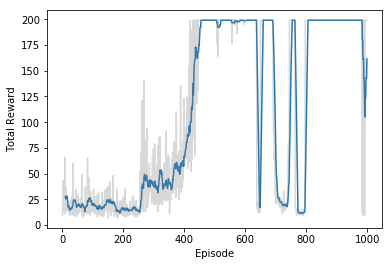

In [13]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Testing

Let's checkout how our trained agent plays the game.

In [14]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

In [184]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.